In [1]:
%matplotlib inline
import numpy as np
import os
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plotting_convention import mark_subplots, simplify_axes

In [2]:
exp_data_folder = join("..", "exp_data", "NPUltraWaveforms")
sim_data_folder = join("..", "exp_data", "simulated")

fig_folder = join(exp_data_folder, "figures")
os.makedirs(fig_folder, exist_ok=True)


x = np.load(join(exp_data_folder, "channels.xcoords.npy"))[:, 0]
z = np.load(join(exp_data_folder, "channels.ycoords.npy"))[:, 0]

waveforms = np.load(join(exp_data_folder, "clusters.waveforms.npy"))


exp_num_tsteps = waveforms.shape[1]
sampling_rate = 30000  # Hz
exp_dt = 1 / sampling_rate * 1000
exp_tvec = np.arange(exp_num_tsteps) * exp_dt
tvec = exp_tvec

elec_sep = x[1] - x[0]


def return_spike_width(eap, dt):
    """ Full width half maximum"""

    if np.max(eap) > np.abs(np.min(eap)):
        return np.NaN

    half_max = np.min(eap) / 2
    t0_idx = None
    t1_idx = None
    for t_idx in range(1, len(eap)):
        if eap[t_idx - 1] > half_max >= eap[t_idx]:
            t0_idx = t_idx if t0_idx is None else t0_idx  # Only record 1st crossing if more
        if eap[t_idx - 1] < half_max <= eap[t_idx]:
            t1_idx = t_idx if t1_idx is None else t1_idx  # Only record 1st crossing if more
    if t0_idx is None:
        print("t0 is None!")
        t0_idx = 0
        # plt.plot(eap)
        # plt.show()
        #return np.NaN
    if t1_idx is None:
        print("t1 is None!")
        t1_idx = len(eap)
        # plt.plot(eap)
        # plt.show()
        # return np.NaN
    return (t1_idx - t0_idx) * dt


In [3]:
jump_size = 1 * elec_sep
num_elecs = len(x)
#print(jump_size)
num_rows, num_cols = (int(num_elecs / 8), 8)


KeyboardInterrupt: 

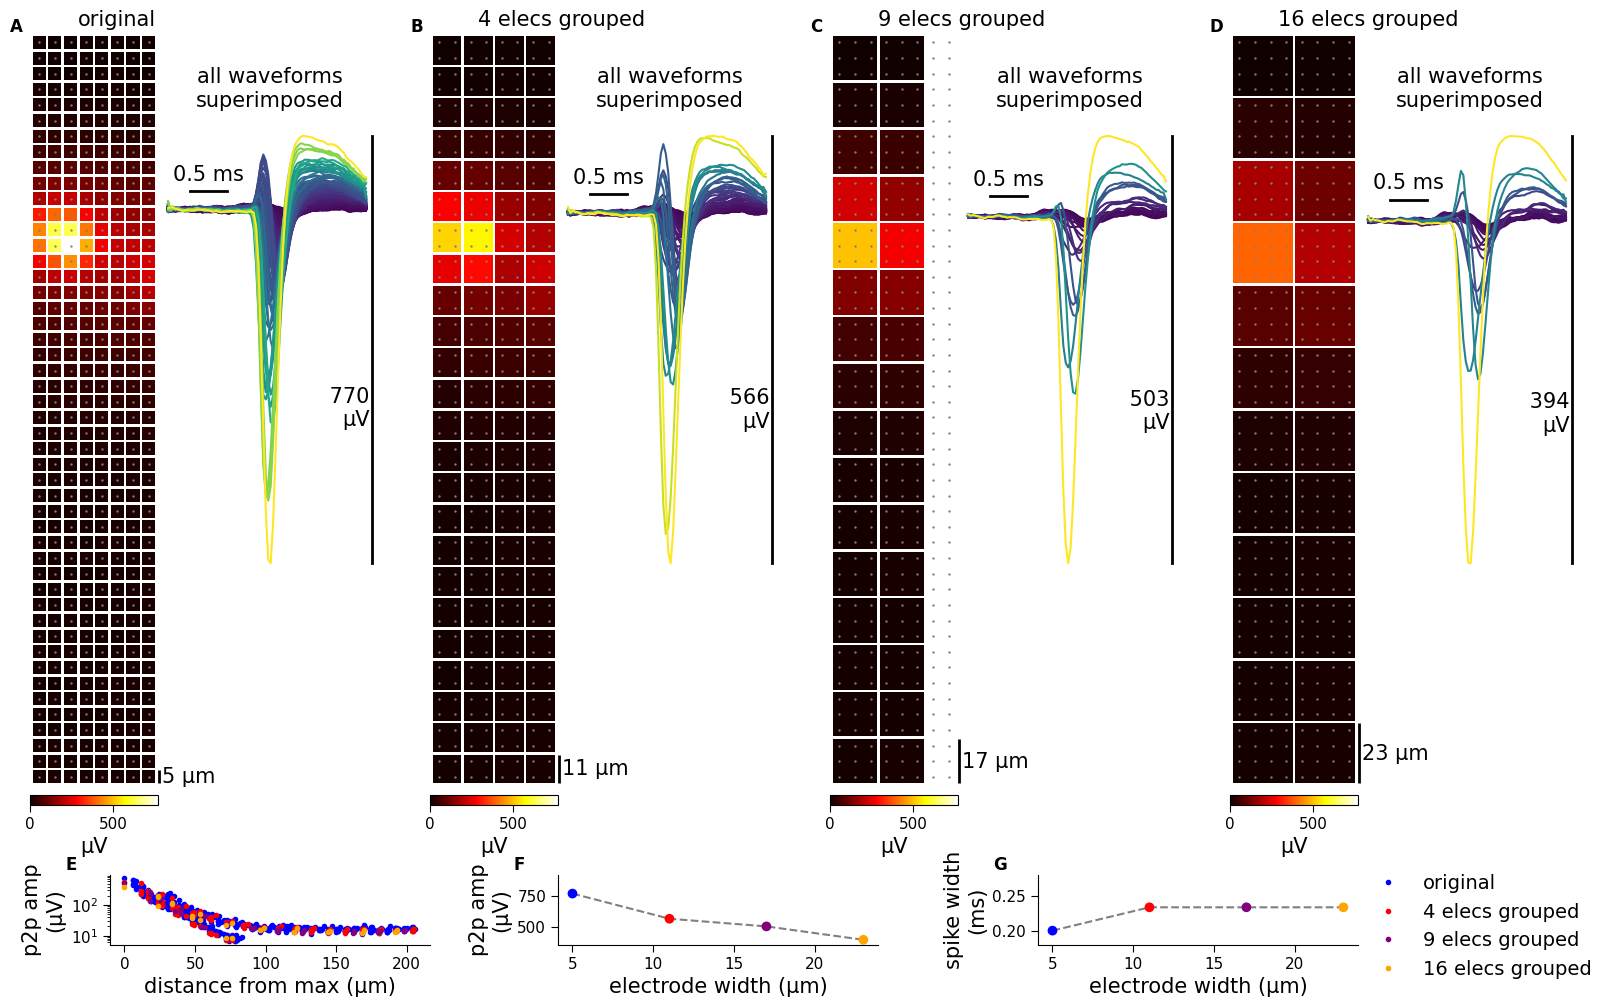

In [4]:

    
def plot_elec_groupings_p2p(waveform_idx):
    waveform = waveforms[waveform_idx]
    max_p2p = np.max(waveform) - np.min(waveform)
    cmap = plt.cm.hot
    elec_clr_func = lambda p2p_amp: cmap(0.0 + p2p_amp / max_p2p)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max_p2p)
    mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    plt.close('all')
    fig = plt.figure(figsize=[16, 10])
    fig.subplots_adjust(bottom=0.25, right=0.97, top=0.99, left=0.05)
    group_clrs = ['b', 'r', 'purple', 'orange']
    
    ax_amp_dist = fig.add_axes([0.07, 0.06, 0.2, 0.07],
                               xlabel="distance from max (µm)",
                               ylabel="p2p amp\n(µV)",
                            yscale="log")
    
    ax_amp_size = fig.add_axes([0.35, 0.06, 0.2, 0.07],
                               xlabel="electrode width (µm)",
                               ylabel="p2p amp\n(µV)")
    
    ax_spike_width = fig.add_axes([0.65, 0.06, 0.2, 0.07],
                               xlabel="electrode width (µm)",
                               ylabel="spike width\n(ms)")
    
    mark_subplots([ax_amp_dist, ax_amp_size, ax_spike_width], "EFGH")
    
    orig_elec_width = 5
    
    #img = plt.imshow([[]], vmin=0, vmax=max_p2p, cmap=cmap)
    
    # std_sorted = np.sort(np.std(waveform, axis=0))
    # std_max = std_sorted[-1]  # largest standard deviation 
    # std_min = np.mean(std_sorted[:10]) # mean of lowest stds
    
    num_elecs_in_groups = [1, 4, 9, 16]
    max_p2ps = []
    elec_widths = []
    spike_widths = []
    
    lines = []
    line_names = []
    for num_seps in range(1, 5):
        num_elecs_in_group = num_elecs_in_groups[num_seps - 1]
        if num_elecs_in_group == 1:
            title = 'original'
        else:
            title = f'{num_elecs_in_group} elecs grouped'
        
        ax1 = fig.add_axes([0.01 + 1 / 4 * (num_seps - 1), 0.22, 0.1, 0.75], aspect=1, 
                              ylim=[-3, np.max(z) + 3], xlim=[-3, np.max(x) + 3], 
                              frameon=False, xticks=[], yticks=[])
        
        fig.text(0.05 + 1 / 4 * (num_seps - 1), 0.995, title, va='top')
        
        ax_eaps = fig.add_axes([0.1 + 1 / 4 * (num_seps - 1), 0.42, 0.14, 0.47], 
                               frameon=False, xticks=[], yticks=[],
                               title="all waveforms\nsuperimposed")
        
        # ax_std = fig.add_axes([0.13 + 1 / 4 * (num_seps - 1), 0.58, 0.1, 0.17],
        #                       ylim=[0, std_max])
        
        cax = fig.add_axes([0.02 + 1 / 4 * (num_seps - 1), 0.20, 0.08, 0.01])
        
        plt.colorbar(mappable, cax=cax, label="µV", orientation='horizontal')
        
        elec_idx_ = 0
        elec_width_ = num_seps * (orig_elec_width) + (num_seps - 1) * 1
        elec_widths.append(elec_width_)
        
        # ax_std.axhline(std_min, lw=0.5, c='gray', ls='--')
        grouped_waveforms = []
        mark_subplots(ax1, ["A", "B", "C", "D"][num_seps-1], ypos=1.01)
        # simplify_axes(ax_std)
        
        xs_ = []
        zs_ = []
        
        
        for row in range(int(num_rows / num_seps)):
            for col in range(int(num_cols / num_seps)):
           
                x_center = (num_seps - 1)/2 * elec_sep + col * num_seps * elec_sep
                z_center = (num_seps - 1)/2 * elec_sep + row * num_seps * elec_sep
                
                xs_.append(x_center)
                zs_.append(z_center)
                
                x0 = x_center-elec_width_/2
                z0 = z_center-elec_width_/2
                
                x1 = x0 + elec_width_
                z1 = z0 + elec_width_
                
                elec_idxs = np.arange(num_elecs)[(x0 <= x) & (x <= x1) & (z0 <= z) & (z <= z1)]
                assert len(elec_idxs) == num_elecs_in_group
    
                waveform_ = np.mean(waveform[:, elec_idxs], axis=1)
                grouped_waveforms.append(waveform_)
                # elec_clr = clrs[num_seps - 1]
                elec_clr = elec_clr_func(np.max(waveform_) - np.min(waveform_))
                
                rect = mpatches.Rectangle((x_center-elec_width_/2 , z_center-elec_width_/2), 
                                          elec_width_, elec_width_, ec="none", fc=elec_clr, zorder=1)
                ax1.add_artist(rect)
                
                elec_idx_ += 1
                
        grouped_waveforms = np.array(grouped_waveforms)
        grouped_p2ps = np.max(grouped_waveforms, axis=1) - np.min(grouped_waveforms, axis=1)
        
        max_elec = np.argmax(grouped_p2ps)
        spike_widths.append(return_spike_width(grouped_waveforms[max_elec], exp_dt))
    
        xs_ = np.array(xs_)
        zs_ = np.array(zs_)
        
        elec_dist_from_max = np.sqrt((xs_ - xs_[max_elec])**2 + (zs_ - zs_[max_elec])**2)
        
        #distsort_idxs = np.argsort(elec_dist_from_max)
        
        l_, = ax_amp_dist.plot(elec_dist_from_max, grouped_p2ps,
                               c=group_clrs[num_seps - 1], ls=' ', marker='.')
        lines.append(l_)
        line_names.append(title)
        
        ax1.plot([np.max(x) + 4, np.max(x) + 4], 
                 [0 - orig_elec_width / 2, 0 - orig_elec_width / 2 + elec_width_], 
                 lw=2, c='k', solid_capstyle='butt', clip_on=False)
        ax1.text(np.max(x) + 5, (-orig_elec_width + elec_width_)/ 2, f"{elec_width_} µm", va='center', ha="left")
        
        max_neg_peak = np.min(grouped_waveforms, axis=1)
        max_pos_peak = np.max(grouped_waveforms, axis=1)    
        p2p = np.max(max_pos_peak - max_neg_peak)
        assert p2p == np.max(grouped_p2ps), "p2p not right!"
        max_p2ps.append(p2p)
        
        eap_clr = lambda eap_min: plt.cm.viridis(0.0 + eap_min / np.min(max_neg_peak))
        for elec_idx_, waveform_ in enumerate(grouped_waveforms):
            ax_eaps.plot(tvec, waveform_, zorder=-np.min(waveform_),
                         c=eap_clr(np.min(waveform_)))
        
        ax_eaps.plot([0.3, 0.8], [np.max(max_pos_peak) / 4, np.max(max_pos_peak) / 4], lw=2, c='k')
        ax_eaps.text(0.55, np.max(max_pos_peak) / 3, "0.5 ms", va="bottom", ha="center")
        
        ax_eaps.plot([2.78, 2.78], [np.min(max_neg_peak), np.max(max_pos_peak)], lw=2, c='k')
        ax_eaps.text(2.75, np.min(max_neg_peak) / 2., f"{p2p: 1.0f}\nµV", va="top", ha="right")
        
        ax1.scatter(x, z, s=0.5, c='gray', zorder=2)
    
    ax_amp_size.plot(elec_widths, max_p2ps, c='gray', zorder=1, ls='--')
    ax_amp_size.scatter(elec_widths, max_p2ps, c=group_clrs, zorder=2)
    ax_amp_size.set_ylim(np.min(max_p2ps) * 0.9, np.max(max_p2ps) * 1.2)
    
    if not np.isnan(spike_widths).any():
        ax_spike_width.plot(elec_widths, spike_widths, c='gray', zorder=1, ls='--')
        ax_spike_width.scatter(elec_widths, spike_widths, c=group_clrs, zorder=2)
        ax_spike_width.set_ylim(np.min(spike_widths) * 0.9, np.max(spike_widths) * 1.2)
        
        ax_spike_width.legend(lines, line_names,
                           frameon=False, ncol=1, loc=(1.01, -0.6))
    else:
        ax_spike_width.remove()
    simplify_axes([ax_amp_dist, ax_amp_size, ax_spike_width])
    fig.savefig(f"elec_groupings_{waveform_idx}.png")


#waveform_idx = 50
#for waveform_idx in range(0, 100):
    #print(waveform_idx)
#    plot_elec_groupings_p2p(waveform_idx)

[5, 11, 17, 23, 29, 35, 41, 47] [225.02622704 198.12334704 174.27599602 153.98398269 136.20021865
 120.80023259 107.49494038  96.10805227] [160.85270347 140.45047724 120.30861487 104.14323698  90.50928132
  79.93163798  71.48903328  64.54853033]


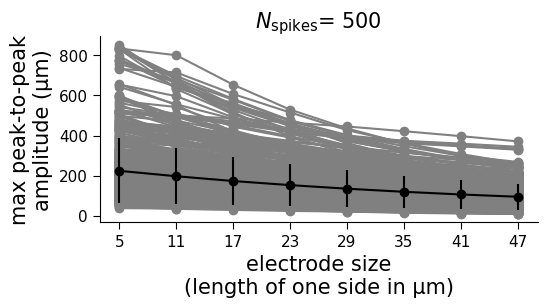

In [37]:

def find_optimal_offset(waveform, num_seps, orig_elec_width, 
                        elec_width_, num_elecs_in_group):
    
    offsets_x = np.arange(0, num_seps) * (orig_elec_width + 1)
    offsets_z = np.arange(0, num_seps) * (orig_elec_width + 1)
    #print(f"Testing {num_seps}: ", offsets_z, offsets_x)
    offset_results = []
    for offset_x in offsets_x:
        for offset_z in offsets_z:
            grouped_waveforms = []
            for row in range(int(num_rows / num_seps)):
                for col in range(int(num_cols / num_seps)):
                    
                    x_center = (num_seps - 1)/2 * elec_sep + col * num_seps * elec_sep + offset_x
                    z_center = (num_seps - 1)/2 * elec_sep + row * num_seps * elec_sep + offset_z
                    
                    x0 = x_center - elec_width_/2
                    x1 = x_center + elec_width_/2
                    z0 = z_center - elec_width_/2
                    z1 = z_center + elec_width_/2
                    
                    elec_idxs = np.arange(num_elecs)[(x0 <= x) & (x <= x1) & 
                                                     (z0 <= z) & (z <= z1)]
        
                    # assert len(elec_idxs) == num_elecs_in_group
                    if not len(elec_idxs) == num_elecs_in_group:
                        continue
                    waveform_ = np.mean(waveform[:, elec_idxs], axis=1)    
                    grouped_waveforms.append(waveform_)
            #print("Num elecs in total: ", len(grouped_waveforms))
            
            max_amp = np.max(np.abs(grouped_waveforms)) if len(grouped_waveforms) > 0 else 0
            offset_results.append([offset_x, offset_z, max_amp])
    offset_results = np.array(offset_results)
    #print(offset_results)
    max_idx = np.argmax(offset_results[:, 2])
    offset_x, offset_z = offset_results[max_idx, :2]
    #print("Chose: ", offset_x, offset_z)
    return offset_x, offset_z

def plot_elec_groupings_centered(waveform_idx, plot_it):
    waveform = waveforms[waveform_idx]
    max_p2p = np.max(waveform) - np.min(waveform)
    max_Ve = np.max(np.abs(waveform))
    
    max_t_idx = np.argmax(np.max(np.abs(waveform), axis=1))
    assert np.max(np.abs(waveform[max_t_idx, :])) == max_Ve
    
    cmap = plt.cm.bwr#plt.cm.PRGn
    elec_clr_func = lambda v_e: cmap((v_e + max_Ve) / (2 * max_Ve))
    
    norm = matplotlib.colors.Normalize(vmin=-max_Ve, vmax=max_Ve)
    mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    t_idx = max_t_idx
    t_idxs = [t_idx]#np.arange(len(tvec))
    
    for t_idx in t_idxs:
        
        if plot_it:
            plt.close('all')
            fig = plt.figure(figsize=[16, 9])
            fig.subplots_adjust(bottom=0.3, right=0.97, top=0.9, left=0.01, wspace=0.3)
            # group_clrs = ['b', 'r', 'purple', 'orange', 'darkcyan']
            
            ax_amp_dist = fig.add_axes([0.15, 0.07, 0.35, 0.15],
                                       xlabel="distance from max (µm)",
                                       ylabel="p2p amp\n(µV)",
                                    yscale="log")
            
            ax_amp_size = fig.add_axes([0.6, 0.07, 0.35, 0.15],
                                       xlabel="electrode width (µm)",
                                       ylabel="p2p amp\n(µV)")
            
            # ax_spike_width = fig.add_axes([0.65, 0.06, 0.2, 0.07],
            #                            xlabel="electrode width (µm)",
            #                            ylabel="spike width\n(ms)")
            
            #mark_subplots([ax_amp_dist, ax_amp_size, ax_spike_width], "EFGH")
            
            
            cax = fig.add_axes([0.03, 0.3, 0.15, 0.01])
            plt.colorbar(mappable, cax=cax, label="µV", orientation='horizontal')
            
    
        orig_elec_width = 5
            
        max_p2ps = []
        elec_widths = []
        spike_widths = []
        
        lines = []
        line_names = []
        
        max_num_seps = 9
        group_clrs = [plt.cm.rainbow(idx_ / (max_num_seps - 1)) 
                      for idx_ in range(max_num_seps - 1)]
    
        num_elecs_in_groups = np.arange(1, max_num_seps)**2
        # max_n[1, 4, 9, 16]

        
        for num_seps in range(1, max_num_seps):
            num_elecs_in_group = num_elecs_in_groups[num_seps - 1]
            if num_elecs_in_group == 1:
                title = 'original'
            else:
                title = f'N$_G$={num_elecs_in_group}'
            
            # ax1 = fig.add_axes([0.01 + 1 / (max_num_seps - 1) * (num_seps - 1), 
            #                     0.22, 0.8 / (2 * max_num_seps), 0.75],
            #                    aspect=1, 
            #                       ylim=[-3, np.max(z) + 3], xlim=[-3, np.max(x) + 3], 
            #                       frameon=False, xticks=[], yticks=[])
            
            if plot_it:
                ax1 = fig.add_subplot(1, (max_num_seps - 1) * 2, (num_seps - 1) * 2 + 1,
                                   aspect=1, 
                                      ylim=[-3, np.max(z) + 3], xlim=[-3, np.max(x) + 3], 
                                      frameon=False, xticks=[], yticks=[])
                
                # fig.text(0.01 + 0.9 / (max_num_seps - 1) * (num_seps - 1), 0.995, title, va='top')
                ax1.text(20, 320, title)
                
                # ax_eaps = fig.add_axes([0.1 + 1 / (max_num_seps - 1) * (num_seps - 1), 
                #                         0.42, 0.8 / (2 * max_num_seps), 0.47], 
                #                        frameon=False, xticks=[], yticks=[],
                                       #title="all waveforms\nsuperimposed"
                                       # )
                
                ax_eaps = fig.add_subplot(2, (max_num_seps - 1) * 2, (num_seps - 1) * 2 + 2, 
                                       frameon=False, xticks=[], yticks=[],
                                       #title="all waveforms\nsuperimposed"
                                       )        
                # ax_std = fig.add_axes([0.13 + 1 / 4 * (num_seps - 1), 0.58, 0.1, 0.17],
                #                       ylim=[0, std_max])
                
                mark_subplots(ax1, 
                              ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"][num_seps-1], 
                      ypos=1.2, xpos=0.1)
            elec_idx_ = 0
            elec_width_ = num_seps * (orig_elec_width) + (num_seps - 1) * 1
            elec_widths.append(elec_width_)
            
            # ax_std.axhline(std_min, lw=0.5, c='gray', ls='--')
            grouped_waveforms = []
            

            # simplify_axes(ax_std)
            
            xs_ = []
            zs_ = []
            
            if num_seps == 1:
                offset_x, offset_z = 0, 0
            else:
                offset_x, offset_z = find_optimal_offset(waveform, num_seps, 
                                                         orig_elec_width, elec_width_,
                                                         num_elecs_in_group)
                
            for row in range(int(num_rows / num_seps)):
                for col in range(int(num_cols / num_seps)):
                    
                    x_center = (num_seps - 1)/2 * elec_sep + col * num_seps * elec_sep + offset_x
                    z_center = (num_seps - 1)/2 * elec_sep + row * num_seps * elec_sep + offset_z
                    
                    x0 = x_center - elec_width_/2
                    x1 = x_center + elec_width_/2
                    z0 = z_center - elec_width_/2
                    z1 = z_center + elec_width_/2
                    
                    elec_idxs = np.arange(num_elecs)[(x0 <= x) & (x <= x1) & (z0 <= z) & (z <= z1)]
    
                    # assert len(elec_idxs) == num_elecs_in_group
                    if not len(elec_idxs) == num_elecs_in_group:
                        continue
                    waveform_ = np.mean(waveform[:, elec_idxs], axis=1)
                        
                    xs_.append(x_center)
                    zs_.append(z_center)
                    grouped_waveforms.append(waveform_)
                    # elec_clr = clrs[num_seps - 1]
                    if plot_it:
                        elec_clr = elec_clr_func(waveform_[t_idx])
                        
                        rect = mpatches.Rectangle((x_center-elec_width_/2 , z_center-elec_width_/2), 
                                                  elec_width_, elec_width_, ec="none", fc=elec_clr, zorder=1)
                        ax1.add_artist(rect)
                    elec_idx_ += 1
                    
            grouped_waveforms = np.array(grouped_waveforms)
            grouped_p2ps = np.max(grouped_waveforms, axis=1) - np.min(grouped_waveforms, axis=1)
            
            max_elec = np.argmax(grouped_p2ps)
            # spike_widths.append(return_spike_width(grouped_waveforms[max_elec], exp_dt))
        
            xs_ = np.array(xs_)
            zs_ = np.array(zs_)
            
            elec_dist_from_max = np.sqrt((xs_ - xs_[max_elec])**2 + (zs_ - zs_[max_elec])**2)
            
            #distsort_idxs = np.argsort(elec_dist_from_max)
            max_pos_peak = np.max(grouped_waveforms, axis=1)    
            max_neg_peak = np.min(grouped_waveforms, axis=1)
            p2p = np.max(max_pos_peak - max_neg_peak)
            assert p2p == np.max(grouped_p2ps), "p2p not right!"
            max_p2ps.append(p2p)
            
            if plot_it:
                l_, = ax_amp_dist.plot(elec_dist_from_max, grouped_p2ps,
                                       c=group_clrs[num_seps - 1], ls=' ', marker='.')
                lines.append(l_)
                line_names.append(title)
                
                ax1.plot([np.max(x) + 4, np.max(x) + 4], 
                         [0 - orig_elec_width / 2, 0 - orig_elec_width / 2 + elec_width_], 
                         lw=2, c='k', solid_capstyle='butt', clip_on=False)
                ax1.text(np.max(x) + 5, (-orig_elec_width + elec_width_)/ 2, 
                         f"{elec_width_} µm", va='center', ha="left", zorder=1000)
                
                

                eap_clr = lambda eap_min: plt.cm.viridis(0.0 + eap_min / np.min(max_neg_peak))
                for elec_idx_, waveform_ in enumerate(grouped_waveforms):
                    ax_eaps.plot(tvec, waveform_, zorder=-np.min(waveform_),
                                 c=eap_clr(np.min(waveform_)))
                ax_eaps.axvline(tvec[t_idx], c='gray', ls='--', lw=0.5)
                ax_eaps.plot([0.3, 0.8], [np.max(max_pos_peak) / 4, np.max(max_pos_peak) / 4], 
                             lw=2, c='k')
                if num_seps == 1:
                    ax_eaps.text(0.55, np.max(max_pos_peak) / 3, "0.5\nms", 
                                 va="bottom", ha="center", zorder=1000)
                
                ax_eaps.plot([2.78, 2.78], [np.min(max_neg_peak), np.max(max_pos_peak)], lw=2, c='k')
                ax_eaps.text(2.78, np.min(max_neg_peak)*1.05, 
                             f"{p2p: 1.0f}\nµV", va="top", ha="center", zorder=1000)
                
                ax1.scatter(x, z, s=0.5, c='gray', zorder=2)
        if plot_it:
            ax_amp_size.plot(elec_widths, max_p2ps, c='gray', zorder=1, ls='--')
            ax_amp_size.scatter(elec_widths, max_p2ps, c=group_clrs, zorder=2)
            ax_amp_size.set_ylim(np.min(max_p2ps) * 0.9, np.max(max_p2ps) * 1.2)
        
        # if not np.isnan(spike_widths).any():
        #     ax_spike_width.plot(elec_widths, spike_widths, c='gray', zorder=1, ls='--')
        #     ax_spike_width.scatter(elec_widths, spike_widths, c=group_clrs, zorder=2)
        #     ax_spike_width.set_ylim(np.min(spike_widths) * 0.9, np.max(spike_widths) * 1.2)
        #     
        #     ax_spike_width.legend(lines, line_names,
        #                        frameon=False, ncol=1, loc=(1.01, -0.6))
        # else:
        #     ax_spike_width.remove()
    
            ax_amp_dist.legend(lines, line_names,
                                   frameon=False, ncol=8, loc=(0.1, 1.1))
            ax_amp_size.set_xticks(elec_widths)
            simplify_axes([ax_amp_dist, ax_amp_size])
            fig.savefig(join("anim", f"elec_groupings_centered_{waveform_idx}_{t_idx:06d}.png"))
        
    return elec_widths, max_p2ps
    
fig_folder = "anim"
#waveform_idx = 50

plot_it = False
max_amp_decay = []

max_p2ps_comb = []
elec_widths = None
num_spikes = 500

for waveform_idx in range(0, num_spikes):
    #if waveform_idx % 10 == 0:
    #print(waveform_idx)
    elec_widths_, max_p2ps = plot_elec_groupings_centered(waveform_idx, plot_it)
    if elec_widths is None:
        elec_widths = elec_widths_
    
    assert elec_widths_ == elec_widths
    
    max_p2ps_comb.append(max_p2ps)
    
    
    #fig_name = f"elec_groupings_centered_{waveform_idx}"
    #cmd = "ffmpeg -framerate 5 -i %s" % os.path.join(
    #    fig_folder, "{:s}_%06d.png ".format(fig_name))
    #cmd += "-c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "
    #cmd += "%s.avi" % join(fig_folder, "..", fig_name)
    # print(cmd)
    #os.system(cmd)
    #rm_cmd = "rm %s/*.png" % fig_folder
    # print(rm_cmd)
    #os.system(rm_cmd)
    
max_p2ps_comb = np.array(max_p2ps_comb)

plt.close("all")
fig = plt.figure(figsize=[6, 3])
fig.subplots_adjust(bottom=0.26, left=0.17)
ax1 = fig.add_subplot(111, xlabel="electrode size\n(length of one side in µm)", 
                     ylabel="max peak-to-peak\namplitude (µm)",
                      title=r"$N_{\rm spikes}$= %d" % num_spikes)

amp_mean = np.mean(max_p2ps_comb, axis=0)
amp_std = np.std(max_p2ps_comb, axis=0)

print(elec_widths, amp_mean, amp_std)

for case_idx in range(len(max_p2ps_comb)):
    ax1.plot(elec_widths, max_p2ps_comb[case_idx], '-o', c='gray')
ax1.errorbar(elec_widths, amp_mean, yerr=amp_std, c='k', ls='-', marker='o')
ax1.set_xticks(elec_widths)
simplify_axes([ax1, ])
fig.savefig("amp_decay_with_elec_size_combined.png")

In [10]:

for waveform_idx in range(60, 61):
    fig_name = f"elec_groupings_centered_{waveform_idx}"
    cmd = "ffmpeg -framerate 5 -i %s" % os.path.join(
        fig_folder, "{:s}_%06d.png ".format(fig_name))
    cmd += "-c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "
    cmd += "%s.avi" % join(fig_folder, "..", fig_name)
    # print(cmd)
    os.system(cmd)
    #rm_cmd = "rm %s/*.png" % fig_folder
    # print(rm_cmd)
    #os.system(rm_cmd)

    

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab